Copyright 2018, Skoltech DeepQauntum Labs, All rights reserved.

# Variational quantum search

Let $n$ be the number of qubits and let $N=2^n$ be the size of the search space. We are searching for a particular bitstring $\omega = \omega_1, \omega_2, \omega_3, ..., \omega_n$. We define a pair of rank-$1$ projectors.
\begin{align}
  \label{def:omega-op}
  P_{\omega} &= |\omega\rangle\langle\omega|\\
  \label{def:plus-op}
  P_{+} &= |+ \rangle\langle +|^{\otimes n} = |s\rangle\langle s|
\end{align}
where $|s\rangle=\frac{1}{\sqrt{N}}\sum_{x\in \left\{0,1\right\}^n} |x\rangle$. To find $|\omega\rangle$, we consider a split-operator variational ansatz, formed by sequencing a pair of operators. These operators prepare a state $|\varphi(\alpha, \beta)\rangle$, with vectors $\alpha = \alpha_1, \alpha_2, ..., \alpha_p$ and $\beta=\beta_1, \beta_2, ..., \beta_p$. We seek to minimize the orthogonal complement of the subspace for the searched string $\omega$.
\begin{align}
\label{eq:projector-w}
P_{\omega^{\perp}} &= I - P_{\omega}
\end{align}
We sometimes call $P_{+}$ the driver Hamiltonian or diffusion operator.
The state $|\varphi(\alpha, \beta)\rangle$ is varied to minimize this orthogonal component.
\begin{align}
\label{eq:minimization}
\min_{\alpha,\beta} \langle \varphi(\alpha, \beta)|P_{\omega^{\perp}}|\varphi(\alpha,\beta)\rangle \geq \min_{|\phi\rangle} \langle \phi|P_{\omega^{\perp}}|\phi\rangle
\end{align}
To prepare the state we develop the sequence
\begin{align}
\label{state_prep}
|\varphi(\alpha,\beta)\rangle = \mathcal{K}(\beta_p) \mathcal{V}(\alpha_p)\cdots\mathcal{K}(\beta_1)\mathcal{V}(\alpha_1)|s\rangle.
\end{align}
Where the operators are defined as
\begin{align}
\label{eq:operator-v}
\mathcal{V}(\alpha) &:= e^{\imath \alpha P_{\omega}}\\
\label{eq:operator-k}
\mathcal{K}(\beta) &:= e^{\imath \beta P_{+}}
\end{align}
The length of the sequence is $2p$, for integer $p$.
We consider now the following problems on which the variational algorithm will work.

### Problem
Write a program which minimizes $\langle \varphi(\alpha, \beta)|P_{\omega^{\perp}}|\varphi(\alpha,\beta)\rangle$  over angles $\beta = (\beta_1, ..., \beta_p)$ and $\alpha = (\alpha_1 , ..., \alpha_p)$ for different $p$. 

Plot overlap between state $|\omega\rangle$ and $|\varphi(\alpha, \beta)\rangle$ with optimal angles for different $p \in[1,2,3,4,5,6]$ for $\omega=0101$:
$$
P_{\alpha,\beta}=|\langle \omega|\varphi(\alpha, \beta)\rangle|^2
$$

In [1]:
import numpy as np
import qit
import matplotlib.pyplot as plt
import pandas as pd
import scipy

Create function in QIT which returns $|x>^{\otimes n}$

In [2]:
def initial_state(n_qubits):
    plus_state=(qit.state('0')+qit.state('1'))/np.sqrt(2)
    state=(qit.state('0')+qit.state('1'))/np.sqrt(2)
    for i in range(1,n_qubits):
        state=qit.state.tensor(state,plus_state)
    return state

Create C operator

In [ ]:
def C_operator(target_state, n_qubits):
       return -1*qit.state.projector(target_state)

Create B operator

In [27]:
def B_operator(n_qubits):
#     plus_state=(qit.state('0')+qit.state('1'))/np.sqrt(2)
#     state=(qit.state('0')+qit.state('1'))/np.sqrt(2)
#     for i in range(1,n_qubits):
#         state=qit.state.tensor(state,plus_state)
    return -1*qit.state.projector(initial_state(n_qubits))

Write a cost function F_function of QAOA as a function of iterations, angles and target state

In [28]:
def qaoa_step(state, target_state, n_qubits, params):
    state=state.propagate(C_operator(target_state,n_qubits).data,params[0])
    return state.propagate(B_operator(n_qubits).data,params[1])  

def F_function(target_state, n_qubits, p, params):
    ini_state=initial_state(n_qubits)
    for i in range(p):
        ini_state=qaoa_step(ini_state,target_state,n_qubits,params=[params[2*i],params[2*i+1]])
    return ini_state.ev(C_operator(target_state,n_qubits).data), ini_state
    
    

Write function to find parameters which minimize F_function

In [29]:
def get_params(target_state, n_qubits, p, params_0):
#     function to optimimize
    def fun(x):
#         we minimize f to find max for F 
        return F_function(target_state, n_qubits, p, params=x)[0]
# starting point
#     params_0=[0.25*np.pi for i in range(2*p)]
    params_min=[0 for i in range(2*p)]
    params_max=[2*np.pi if i%2==0 else np.pi for i in range(2*p)]
    # the bounds required by L-BFGS-B
    bounds = [(low, high) for low, high in zip(params_min, params_max)]

# use method L-BFGS-B because the problem is smooth and bounded
    minimizer_kwargs = dict(method="L-BFGS-B", bounds=bounds)
    result = scipy.optimize.basinhopping(fun, params_0, minimizer_kwargs=minimizer_kwargs)
    return [result.x[i] for i in range(2*p)]    

###################################################################################
###################################################################################

Write a function which returns overlap between target state and QAOA approximation as a function of p (number of iterations of QAOA). Calculate this function for target state $|0101>$ as a function of QAOA iterations $p=[1,2,3,4,5]$

In [33]:
def calc_n_p(target_state,n_qbits,p_steps):
    n = n_qbits
    qaoa_approximation = []
    p_array = []
    params=[0.5*np.pi,0.5*np.pi]
    for i in range(1,p_steps+1):
        params=get_params(target_state=target_state,p=i,n_qubits=n,params_0=params)
        f_value, state_2=F_function(target_state=target_state,params=params,p=i,n_qubits=n)
        qaoa_approximation.append(qit.state.fidelity(target_state,state_2)**2)
        p_array.append(i)
        print('Iteration ', i)
        print('Cost function value ', f_value)
        params.extend([0,0])


    return qaoa_approximation, p_array

In [34]:
overlap_val, p_val = calc_n_p(qit.state('0101'),4,5)

Iteration  1
Cost function value  -0.47265625
Iteration  2
Cost function value  -0.9084472656249355
Iteration  3
Cost function value  -0.9999999999999958
Iteration  4
Cost function value  -0.9999999999999984
Iteration  5
Cost function value  -0.9999999999999999


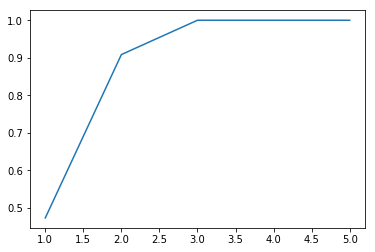

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figsize=(10,10)
plt.plot(p_val,overlap_val)
plt.show()